In [1]:
# Install openyxl for xlsx files since Pandas no longer supports them natively
!pip install openpyxl

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
import itertools
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img,img_to_array

from keras.utils import np_utils
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Reshape, Dropout
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

     |████████████████████████████████| 242 kB 482 kB/s            


In [2]:
img_dir = '../input/ocular-disease-recognition-odir5k/preprocessed_images'

In [8]:
data = pd.read_csv('../input/ocular-disease-recognition-odir5k/full_df.csv')
data[:10]

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg
5,6,60,Male,6_left.jpg,6_right.jpg,macular epiretinal membrane,moderate non proliferative retinopathy，epireti...,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",6_right.jpg
6,7,60,Female,7_left.jpg,7_right.jpg,drusen,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",7_right.jpg
7,8,59,Male,8_left.jpg,8_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",8_right.jpg
8,9,54,Male,9_left.jpg,9_right.jpg,normal fundus,vitreous degeneration,0,0,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['O'],"[0, 0, 0, 0, 0, 0, 0, 1]",9_right.jpg
9,10,70,Male,10_left.jpg,10_right.jpg,epiretinal membrane,normal fundus,0,0,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",10_right.jpg


In [9]:
data2 = data.iloc[:,7:15]
data2

,N,D,G,C,A,H,M,O
0,0,0,0,1,0,0,0,0
1,1,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,1
3,0,1,0,0,0,0,0,1
4,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
6387,0,1,0,0,0,0,0,0
6388,0,1,0,0,0,0,0,0
6389,0,1,0,0,0,0,0,0
6390,0,1,0,0,0,0,0,0


In [10]:
data.describe()

,ID,Patient Age,N,D,G,C,A,H,M,O
count,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000
mean,2271.150814,57.857947,0.328692,0.332134,0.062109,0.062891,0.049906,0.031758,0.047872,0.248436
std,1417.559018,11.727737,0.469775,0.471016,0.241372,0.242786,0.217768,0.175370,0.213513,0.432139
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,920.750000,51.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2419.500000,59.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3294.000000,66.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4784.000000,91.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
from collections import Counter


In [12]:
#Selecting columns from ID to Right Diagnostic keywords

In [13]:
data_copy = data.iloc[:,0:7]
data_copy.head(5)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy


In [16]:
data_left = data_copy[data_copy['Left-Diagnostic Keywords'].str.match('glaucoma')]
data_left

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords
129,153,79,Male,153_left.jpg,153_right.jpg,glaucoma,dry age-related macular degeneration
141,167,71,Male,167_left.jpg,167_right.jpg,glaucoma,glaucoma
510,583,54,Male,583_left.jpg,583_right.jpg,glaucoma,glaucoma
986,1209,69,Female,1209_left.jpg,1209_right.jpg,glaucoma,glaucoma
987,1210,62,Male,1210_left.jpg,1210_right.jpg,glaucoma,glaucoma
...,...,...,...,...,...,...,...
4537,1986,70,Male,1986_left.jpg,1986_right.jpg,glaucoma,myelinated nerve fibers，drusen
4547,2030,66,Male,2030_left.jpg,2030_right.jpg,glaucoma,mild nonproliferative retinopathy，glaucoma，vit...
4550,2041,55,Female,2041_left.jpg,2041_right.jpg,glaucoma，wet age-related macular degeneration,tessellated fundus
4554,2063,77,Male,2063_left.jpg,2063_right.jpg,glaucoma，lens dust,glaucoma，moderate non proliferative retinopath...


In [17]:
data_right = data_copy[data_copy['Right-Diagnostic Keywords'].str.match('glaucoma')]
data_right

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords
141,167,71,Male,167_left.jpg,167_right.jpg,glaucoma,glaucoma
510,583,54,Male,583_left.jpg,583_right.jpg,glaucoma,glaucoma
986,1209,69,Female,1209_left.jpg,1209_right.jpg,glaucoma,glaucoma
987,1210,62,Male,1210_left.jpg,1210_right.jpg,glaucoma,glaucoma
988,1211,80,Male,1211_left.jpg,1211_right.jpg,glaucoma，optic nerve atrophy,glaucoma，optic nerve atrophy
...,...,...,...,...,...,...,...
4527,1963,57,Female,1963_left.jpg,1963_right.jpg,moderate non proliferative retinopathy,glaucoma
4530,1967,54,Male,1967_left.jpg,1967_right.jpg,glaucoma,glaucoma
4535,1977,70,Male,1977_left.jpg,1977_right.jpg,glaucoma,glaucoma
4551,2048,63,Male,2048_left.jpg,2048_right.jpg,hypertensive retinopathy,glaucoma，old central retinal vein occlusion


In Cataract problem, most of the cases were having one eye has cataract and the other one normal. But for Glaucoma in most of the cases both left and right eye have got the disease.

In [19]:
#Combine both data
data_glaucoma = data_right['Right-Fundus'].append(data_left['Left-Fundus'], ignore_index = True)
data_glaucoma

0       167_right.jpg
1       583_right.jpg
2      1209_right.jpg
3      1210_right.jpg
4      1211_right.jpg
            ...      
489     1986_left.jpg
490     2030_left.jpg
491     2041_left.jpg
492     2063_left.jpg
493     2074_left.jpg
Length: 494, dtype: object

In [20]:
len(data_glaucoma)

494

check few samples

In [21]:
data_glaucoma[141]

'1237_right.jpg'

(512, 512, 3)
1237_right.jpg


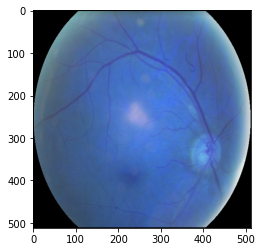

In [22]:
img = data_glaucoma[141]
image = cv2.imread(os.path.join(img_dir,img))
plt.imshow(image)
print(image.shape)
print(img)

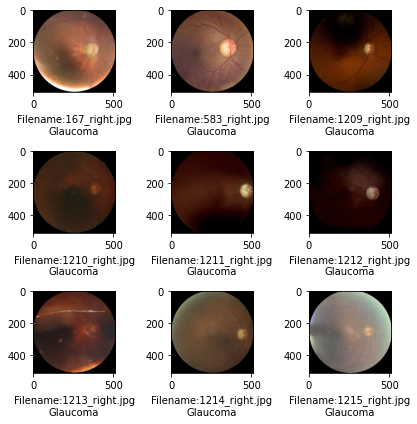

In [23]:
plt.figure(figsize = (6,6))
for i in range(9):
    img = data_glaucoma[i]
    image = cv2.imread(os.path.join(img_dir,img))
    rgb_image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    plt.subplot(3,3,i+1)
    plt.imshow(rgb_image)
    plt.xlabel('Filename:{}\n''Glaucoma'.format(data_glaucoma[i]))
    plt.tight_layout()

Make a dataframe for normal images

In [24]:
data_ln = data_copy[data_copy['Left-Diagnostic Keywords'].str.match('normal')]
data_ln

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus
7,8,59,Male,8_left.jpg,8_right.jpg,normal fundus,normal fundus
8,9,54,Male,9_left.jpg,9_right.jpg,normal fundus,vitreous degeneration
12,14,55,Male,14_left.jpg,14_right.jpg,normal fundus,macular epiretinal membrane
13,15,50,Male,15_left.jpg,15_right.jpg,normal fundus,myelinated nerve fibers
...,...,...,...,...,...,...,...
6356,4637,45,Male,4637_left.jpg,4637_right.jpg,normal fundus,normal fundus
6358,4639,60,Female,4639_left.jpg,4639_right.jpg,normal fundus,mild nonproliferative retinopathy
6360,4641,56,Male,4641_left.jpg,4641_right.jpg,normal fundus,mild nonproliferative retinopathy
6378,4672,65,Male,4672_left.jpg,4672_right.jpg,normal fundus,mild nonproliferative retinopathy


In [25]:
data_rn = data_copy[data_copy['Right-Diagnostic Keywords'].str.match('normal')]
data_rn

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus
7,8,59,Male,8_left.jpg,8_right.jpg,normal fundus,normal fundus
9,10,70,Male,10_left.jpg,10_right.jpg,epiretinal membrane,normal fundus
24,29,59,Male,29_left.jpg,29_right.jpg,epiretinal membrane,normal fundus
...,...,...,...,...,...,...,...
6361,4642,52,Male,4642_left.jpg,4642_right.jpg,mild nonproliferative retinopathy,normal fundus
6363,4644,60,Female,4644_left.jpg,4644_right.jpg,mild nonproliferative retinopathy,normal fundus
6373,4660,51,Male,4660_left.jpg,4660_right.jpg,mild nonproliferative retinopathy,normal fundus
6377,4671,48,Male,4671_left.jpg,4671_right.jpg,mild nonproliferative retinopathy,normal fundus


In [27]:
#combine both
data_normal = data_rn['Right-Fundus'].append(data_ln['Left-Fundus'],ignore_index = True)
data_normal

0         0_right.jpg
1         1_right.jpg
2         8_right.jpg
3        10_right.jpg
4        29_right.jpg
            ...      
5585    4637_left.jpg
5586    4639_left.jpg
5587    4641_left.jpg
5588    4672_left.jpg
5589    4683_left.jpg
Length: 5590, dtype: object

In [28]:
len(data_normal)

5590

In [34]:
data_normal_rand = data_normal.sample(n=650)
data_normal_rand.head()
#since glaucoma cases are 494, taking 650 normal cases

3027    2361_left.jpg
4666    2574_left.jpg
2993    2197_left.jpg
174     906_right.jpg
4500    2395_left.jpg
dtype: object

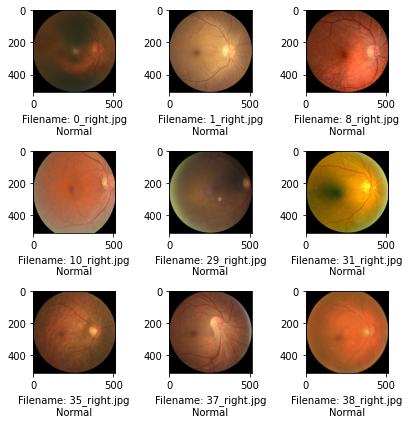

In [29]:
# Visualise few samples
plt.figure(figsize=(6,6))
for i in range(9):
    img = data_normal[i]
    image = cv2.imread(os.path.join(img_dir,img))
    rgb_image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    plt.subplot(3,3,i+1)
    plt.imshow(rgb_image)
    plt.xlabel('Filename: {}\n''Normal'.format(data_normal[i]))
    plt.tight_layout()

In [30]:
print(type(data_normal))

<class 'pandas.core.series.Series'>


Change both lists of normal and gaucoma to dataframes

In [31]:
gaucoma_df = pd.DataFrame(data_glaucoma, columns =['images'])
gaucoma_df

,images
0,167_right.jpg
1,583_right.jpg
2,1209_right.jpg
3,1210_right.jpg
4,1211_right.jpg
...,...
489,1986_left.jpg
490,2030_left.jpg
491,2041_left.jpg
492,2063_left.jpg


In [32]:
#add label column as 'Glaucoma'
gaucoma_df['label'] = 'glaucoma'
gaucoma_df

,images,label
0,167_right.jpg,glaucoma
1,583_right.jpg,glaucoma
2,1209_right.jpg,glaucoma
3,1210_right.jpg,glaucoma
4,1211_right.jpg,glaucoma
...,...,...
489,1986_left.jpg,glaucoma
490,2030_left.jpg,glaucoma
491,2041_left.jpg,glaucoma
492,2063_left.jpg,glaucoma


In [76]:
normal_df = pd.DataFrame(data_normal,columns =['images'])
normal_df

,images
0,0_right.jpg
1,1_right.jpg
2,8_right.jpg
3,10_right.jpg
4,29_right.jpg
...,...
5585,4637_left.jpg
5586,4639_left.jpg
5587,4641_left.jpg
5588,4672_left.jpg


In [86]:
#add label column as 'normal'
normal_df['label'] = 'normal'
normal_df

,images,label
0,0_right.jpg,normal
1,1_right.jpg,normal
2,8_right.jpg,normal
3,10_right.jpg,normal
4,29_right.jpg,normal
...,...,...
5585,4637_left.jpg,normal
5586,4639_left.jpg,normal
5587,4641_left.jpg,normal
5588,4672_left.jpg,normal


In [92]:
#combine both
df_combined = gaucoma_df.append(normal_df, ignore_index= True)
df_combined

,images,label
0,167_right.jpg,glaucoma
1,583_right.jpg,glaucoma
2,1209_right.jpg,glaucoma
3,1210_right.jpg,glaucoma
4,1211_right.jpg,glaucoma
...,...,...
6079,4637_left.jpg,normal
6080,4639_left.jpg,normal
6081,4641_left.jpg,normal
6082,4672_left.jpg,normal


Prior to feeding this organized set of cataract and normal images we need to randomize the rows within so that when we train we will train from a random pool of samples.

If we append, we end up adding a column for the old index values, which we don't want any new columns, so we'll drop the old index and allow the new dataframe to have a new one

In [99]:
df = df_combined.sample(frac=1).reset_index(drop=True)

,images,label
500,741_right.jpg,normal
501,2599_right.jpg,normal
502,4689_right.jpg,normal
503,91_left.jpg,normal
504,3070_left.jpg,normal
505,3218_right.jpg,normal
506,3375_right.jpg,normal
507,115_right.jpg,normal
508,2841_left.jpg,normal
509,1345_left.jpg,glaucoma
